# Navigation

---

In this notebook we attempt to solve a reinforcement learning environment where an agent will be collecting rewards in a 3D space. Yellow bananas give a positive reward while blue bananas give a negative reward. Our agent can move forward and backward and can turn left and right. Each episode is limited to 300 time steps.

For solving this environment, we've created a Deep Q Network agent, and a Double Deep Q Network agent. We compare the results and see which one reaches the target average score of 13 over the last 100 episodes first.
### 1. Import required packages


In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agents.dqn import DQNAgent
from agents.double_dqn import DoubleDQNAgent
from agents.utils import Trainer
import torch
import matplotlib.pyplot as plt

### 2. Start the environment
Initialize Unity 3D based environment from its application binary.

In [2]:
env = UnityEnvironment(file_name="C:\\Users\\saini\\Documents\\Work\\learning\\drlnd\\p1_navigation\\Banana_Windows_x86_64\\Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Print details about the environment

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. Define functions to play an episode and solve the environment
Here we define functions to play a single episode, and to run the episodes till environment is solved.

In [4]:
def interpolate(x1, x2, y1, y2, x):
    """Interpolate a value y using x linearly

    Args:
        x1 (float): x1
        x2 (float): x2
        y1 (float): y1
        y2 (float): y2
        x (float): x

    Returns:
        float: interpolated value
    """
    return y1 + (x - x1) * (y2 - y1) / (x2 - x1)

def play_episode(env, agent, max_steps=500, trainer=None, eps=0.0):
    """Execute a single episode in environment env using agent.

    Args:
        env (UnityEnvironment): Unity 3D environment
        agent (Agent): reinforcement learning agent
        max_steps (int, optional): Maximum number of steps to play in the environment. Defaults to 500.
        trainer (Trainer, optional): Trainer to execute learning updates. Only updates the agent if a trainer is passed, otherwise plays the episode in evaluation mode.
        eps (float, optional): Exploration factor. Defaults to 0.0.

    Returns:
        int: score collected by the agent
    """
    env_info = env.reset(train_mode=True if trainer else False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    steps = 0
    while True:
        action = int(agent.compute_action(state, eps))      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        steps += 1

        if trainer:
            trainer.step(state, action, reward, next_state, done)

        state = next_state                             # roll over the state to next time step
        if done or steps>=max_steps:                   # exit loop if episode finished
            break
    return score

def solve_env(env, agent, max_episodes, trainer, start_eps=0.1, stop_eps=0.01):
    """Attempts to solve the given environment using given agent. Interpolates the exploration factor as training progresses.

    Args:
        env (UnityEnvironment): Unity 3D environment
        agent (Agent): reinforcement learning agent
        max_episodes (int): maximum number of episodes to play in the trial
        trainer (Trainer): Trainer to execute learning updates
        start_eps (float, optional): Starting exploration factor. Defaults to 0.1.
        stop_eps (float, optional): Exploration factor at max_episodes. Defaults to 0.01.

    Returns:
        array_like: Scores attained by the agent over all episodes
    """
    scores = []
    for i in range(max_episodes):
        eps = interpolate(0, max_episodes, start_eps, stop_eps, i)
        score = play_episode(env, agent, trainer=trainer, eps=eps)
        scores.append(score)
        
        avg_score = np.mean(scores[-100:])
        if avg_score > 13:
            print("Solved at episode {}".format(i))
            break
        elif (i+1)%100 == 0:
            print("episode : {:5d},\tavg score : {:3.2f}, \tepsilon : {:1.2f}".format(i+1, avg_score, eps))
    return scores

### 5. Train DQN agent
Create a DQN agent and attempt to solve the environment using it.

In [5]:
max_episodes = 2000
device = torch.device("cpu")

# initialize DQN agent
agent = DQNAgent(state_size, action_size, 0.98, 1e-3, 760, device, 0.4)
# initialize Trainer
trainer = Trainer(agent, batch_size=64, update_every=64, min_samples=2048, replay_buffer_size=4096, device=device)
# attempt to solve the environment using DQNAgent
dqn_scores = solve_env(env, agent, max_episodes, trainer)
# save the model
torch.save(agent.qnetwork_local.state_dict(), 'checkpoints/dqn.pth')

episode :   100,	avg score : 4.09, 	epsilon : 0.10
episode :   200,	avg score : 6.13, 	epsilon : 0.09
episode :   300,	avg score : 7.96, 	epsilon : 0.09
episode :   400,	avg score : 8.53, 	epsilon : 0.08
episode :   500,	avg score : 8.04, 	epsilon : 0.08
episode :   600,	avg score : 7.97, 	epsilon : 0.07
episode :   700,	avg score : 10.60, 	epsilon : 0.07
episode :   800,	avg score : 10.42, 	epsilon : 0.06
episode :   900,	avg score : 10.55, 	epsilon : 0.06
episode :  1000,	avg score : 9.97, 	epsilon : 0.06
episode :  1100,	avg score : 11.84, 	epsilon : 0.05
episode :  1200,	avg score : 12.10, 	epsilon : 0.05
episode :  1300,	avg score : 12.15, 	epsilon : 0.04
episode :  1400,	avg score : 10.41, 	epsilon : 0.04
episode :  1500,	avg score : 11.10, 	epsilon : 0.03
episode :  1600,	avg score : 11.02, 	epsilon : 0.03
episode :  1700,	avg score : 11.74, 	epsilon : 0.02
Solved at episode 1792


### 6. Train Double DQN agent
Create a Double DQN agent and solve the enviro

In [6]:
# initialize Double DQN agent
agent = DoubleDQNAgent(state_size, action_size, 0.98, 1e-3, 760, device, 0.4)
# initialize Trainer
trainer = Trainer(agent, batch_size=64, update_every=64, min_samples=2048, replay_buffer_size=4096, device=device)
# attempt to solve the environment using DoubleDQNAgent
ddqn_scores = solve_env(env, agent, max_episodes, trainer)
# save the model
torch.save(agent.qnetwork_local.state_dict(), 'checkpoints/ddqn.pth')

episode :   100,	avg score : 3.39, 	epsilon : 0.10
episode :   200,	avg score : 5.88, 	epsilon : 0.09
episode :   300,	avg score : 7.89, 	epsilon : 0.09
episode :   400,	avg score : 8.41, 	epsilon : 0.08
episode :   500,	avg score : 8.00, 	epsilon : 0.08
episode :   600,	avg score : 9.78, 	epsilon : 0.07
episode :   700,	avg score : 9.54, 	epsilon : 0.07
episode :   800,	avg score : 9.69, 	epsilon : 0.06
episode :   900,	avg score : 11.11, 	epsilon : 0.06
episode :  1000,	avg score : 10.42, 	epsilon : 0.06
episode :  1100,	avg score : 12.75, 	epsilon : 0.05
episode :  1200,	avg score : 11.98, 	epsilon : 0.05
episode :  1300,	avg score : 11.51, 	epsilon : 0.04
episode :  1400,	avg score : 12.06, 	epsilon : 0.04
episode :  1500,	avg score : 12.27, 	epsilon : 0.03
Solved at episode 1560


### 7. Plot scores and moving averages

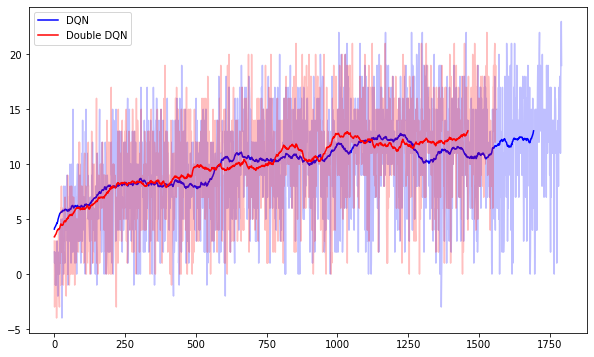

In [7]:
def moving_average(x, w):
    """Calculates moving average of array x over window w"""
    return np.convolve(x, np.ones(w), 'valid') / w

# plot the raw scores with moving averages
plt.figure(figsize=(10, 6))
plt.plot(dqn_scores, 'b', alpha=0.25)
plt.plot(moving_average(dqn_scores, 100), 'b', label='DQN')
plt.plot(ddqn_scores, 'r', alpha=0.25)
plt.plot(moving_average(ddqn_scores, 100), 'r', label='Double DQN')
plt.legend()
plt.show()

### 8. Play an episode with trained DDQN agent

In [14]:
play_episode(env, agent)

16.0

### 9. Shutdown the environment

In [15]:
env.close()